In [1]:
%pip install trimesh vedo


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\joseg\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Volumen objetivo (número de voxeles): 6466.5
Componentes principales de la malla 1 (Sphere.obj):
[[ 0.         -1.          0.00000008]
 [ 1.         -0.         -0.00001769]
 [-0.00001769 -0.00000008 -1.        ]]
Componentes principales de la malla 2 (Cubo.obj):
[[ 0.00366686 -0.02514121  0.99967718]
 [ 0.99998502  0.00415531 -0.00356349]
 [-0.00406437  0.99967527  0.02515607]]


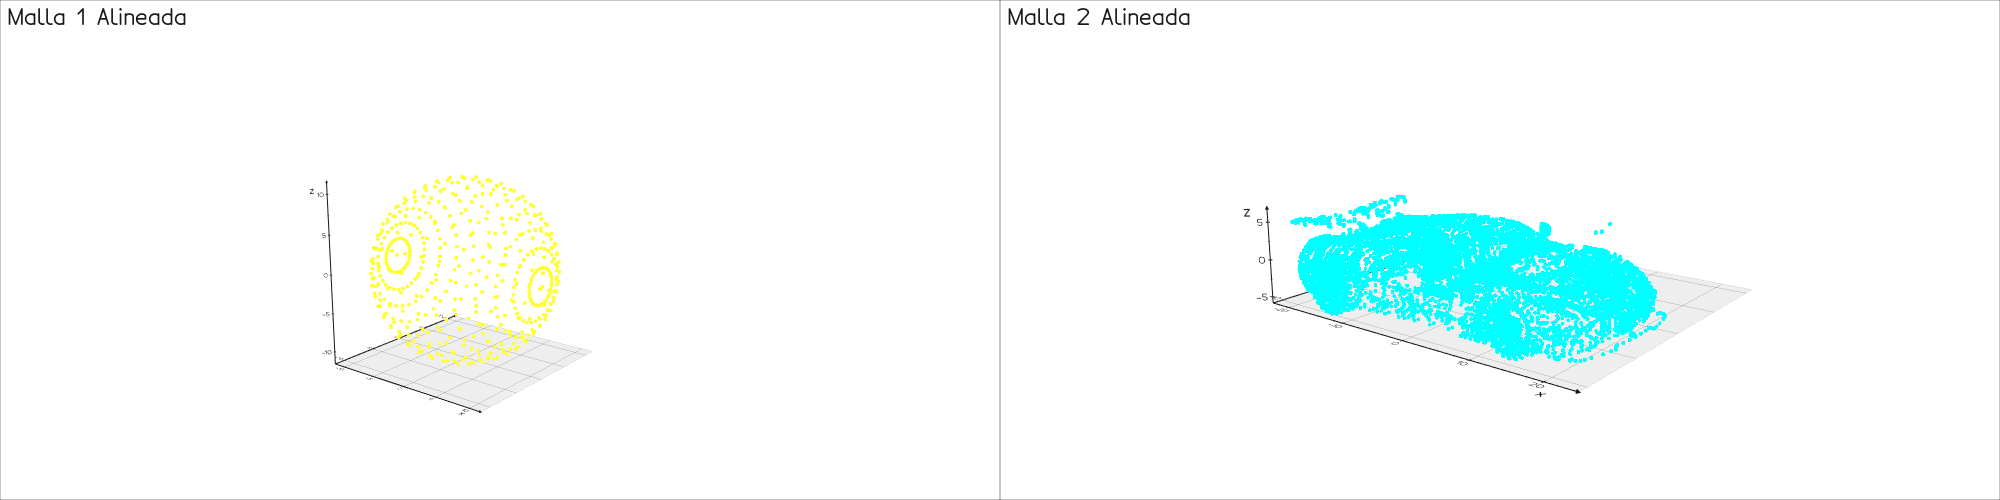

In [14]:
import numpy as np
import trimesh
from vedo import Plotter, Points
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# Función para escalar el objeto a un volumen deseado
def scale_to_volume(mesh, target_volume):
    current_volume = mesh.volume
    scale_factor = (target_volume / current_volume) ** (1/3)
    mesh.apply_scale(scale_factor)
    return mesh

# Función para calcular la compacidad discreta de una malla voxelizada
def calculate_discrete_compacity(voxels):
    voxel_points = voxels.points
    n = len(voxel_points)
    
    # Crear una matriz de adyacencia 3D
    adj_matrix = np.zeros((n, 6), dtype=bool)
    
    # Definir desplazamientos para vecinos adyacentes en 6 direcciones
    neighbors = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])
    
    voxel_set = set(map(tuple, voxel_points))
    
    for i, point in enumerate(voxel_points):
        for j, neighbor in enumerate(neighbors):
            neighbor_point = tuple(point + neighbor)
            if neighbor_point in voxel_set:
                adj_matrix[i, j] = True
    
    # Área de contacto (caras expuestas)
    A_c = 6 * n - adj_matrix.sum()
    
    # A_min y A_max
    A_min = n - 1
    A_max = 3 * (n - n ** (2 / 3))
    
    # Calcular la compacidad discreta
    if A_max - A_min == 0:  # Evitar división por cero
        return 1.0
    compacity = (A_c - A_min) / (A_max - A_min)
    
    return compacity

# Función para mover los vóxeles con la menor distancia usando el método húngaro
def move_voxels_hungarian(source_points, target_points):
    # Calcular la matriz de costos (distancias)
    cost_matrix = np.linalg.norm(source_points[:, np.newaxis] - target_points, axis=2)
    
    # Resolver el problema de asignación usando el método húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Obtener los vóxeles movidos
    moved_voxels = target_points[col_ind]
    
    return moved_voxels

# Cargar los archivos .obj
scene1 = trimesh.load_mesh('D://respaldo//todo//Ai_lab_school//vision//escalamiento_3d//Sphere.obj')
scene2 = trimesh.load_mesh('D://respaldo//todo//Ai_lab_school//vision//escalamiento_3d//Koe.obj')

# Verificar si la carga fue una escena con múltiples geometrías
if isinstance(scene1, trimesh.Scene):
    combined_mesh1 = trimesh.util.concatenate(scene1.dump())
else:
    combined_mesh1 = scene1

if isinstance(scene2, trimesh.Scene):
    combined_mesh2 = trimesh.util.concatenate(scene2.dump())
else:
    combined_mesh2 = scene2

# Voxelizar con una resolución inicial para calcular el número de voxeles
initial_voxels1 = combined_mesh1.voxelized(pitch=1)
initial_voxels2 = combined_mesh2.voxelized(pitch=1)

num_voxels1 = len(initial_voxels1.points)
num_voxels2 = len(initial_voxels2.points)

# Calcular el volumen objetivo como el promedio del número de voxeles
target_volume = (num_voxels1 + num_voxels2) / 2
print(f"Volumen objetivo (número de voxeles): {target_volume}")

# Escalar ambos objetos para que tengan el mismo volumen objetivo
scaled_mesh1 = scale_to_volume(combined_mesh1, target_volume)
scaled_mesh2 = scale_to_volume(combined_mesh2, target_volume)

# Alineación usando PCA
points1 = scaled_mesh1.vertices
points2 = scaled_mesh2.vertices

pca1 = PCA(n_components=3)
pca2 = PCA(n_components=3)

pca1.fit(points1)
pca2.fit(points2)

aligned_points1 = pca1.transform(points1)
aligned_points2 = pca2.transform(points2)

print("Componentes principales de la malla 1 (Sphere.obj):")
print(pca1.components_)

print("Componentes principales de la malla 2 (Cubo.obj):")
print(pca2.components_)

# Crear mallas alineadas
aligned_mesh1 = trimesh.Trimesh(vertices=aligned_points1, faces=scaled_mesh1.faces)
aligned_mesh2 = trimesh.Trimesh(vertices=aligned_points2, faces=scaled_mesh2.faces)

# Convertir las mallas a vóxeles
voxels1 = aligned_mesh1.voxelized(pitch=1)
voxels2 = aligned_mesh2.voxelized(pitch=1)

# Calcular la compacidad discreta de las mallas voxelizadas
compacity1 = calculate_discrete_compacity(voxels1)
compacity2 = calculate_discrete_compacity(voxels2)

voxel_points1 = voxels1.points
voxel_points2 = voxels2.points

# Mover los vóxeles de la primera malla a la segunda con la menor distancia usando el método húngaro
moved_voxel_points = move_voxels_hungarian(voxel_points1, voxel_points2)

# Crear un volumen de la matriz de vóxeles movidos
moved_volume = Points(moved_voxel_points, r=4, c='green')

# Crear volúmenes de las matrices de vóxeles
volume1 = Points(voxel_points1, r=4, c='red')
volume2 = Points(voxel_points2, r=4, c='blue')

# Visualizar los volúmenes escalados y voxelizados
plotter = Plotter(shape=(1, 3), size=(2000, 500))
plotter.show(volume1, "Malla 1 Escalada y Voxelizada", at=0, axes=1, viewup="z", zoom=1)
plotter.show(volume2, "Malla 2 Escalada y Voxelizada", at=1, axes=1, viewup="z", zoom=1)
plotter.show(moved_volume, "Vóxeles Movidos", at=2, axes=1, viewup="z", zoom=1.5)

# Visualizar las mallas alineadas usando PCA
aligned_volume1 = Points(aligned_points1, r=4, c='yellow')
aligned_volume2 = Points(aligned_points2, r=4, c='cyan')

# Crear un nuevo plotter para las mallas alineadas
plotter_aligned = Plotter(shape=(1, 2), size=(2000, 500))
plotter_aligned.show(aligned_volume1, "Malla 1 Alineada", at=0, axes=1, viewup="z", zoom=1)
plotter_aligned.show(aligned_volume2, "Malla 2 Alineada", at=1, axes=1, viewup="z", zoom=1)


Meshes loaded and combined.
[[-10.71442245  -4.5053292   -0.60346773]
 [-10.71442245  -4.5053292   -0.60346773]
 [-10.71442245  -4.5053292   -0.60346773]
 ...
 [-36.44555673   3.30859215  -2.54397088]
 [-36.44555673   3.30859215  -2.54397088]
 [-36.44555673   3.30859215  -2.54397088]]
Componentes principales de la malla 1 (Sphere.obj):
[[ 0.02935493 -0.93393661  0.35623125]
 [-0.56326346 -0.30986925 -0.76597345]
 [ 0.82575575 -0.17816695 -0.53514855]]
Componentes principales de la malla 2 (Cubo.obj):
[[-0.99999999  0.00007677  0.00009398]
 [-0.00000312  0.75795944 -0.65230168]
 [-0.00012131 -0.65230168 -0.75795943]]
Compacidad de la malla 1: 0.5522154130174409
Compacidad de la malla 2: 0.2878294937150301


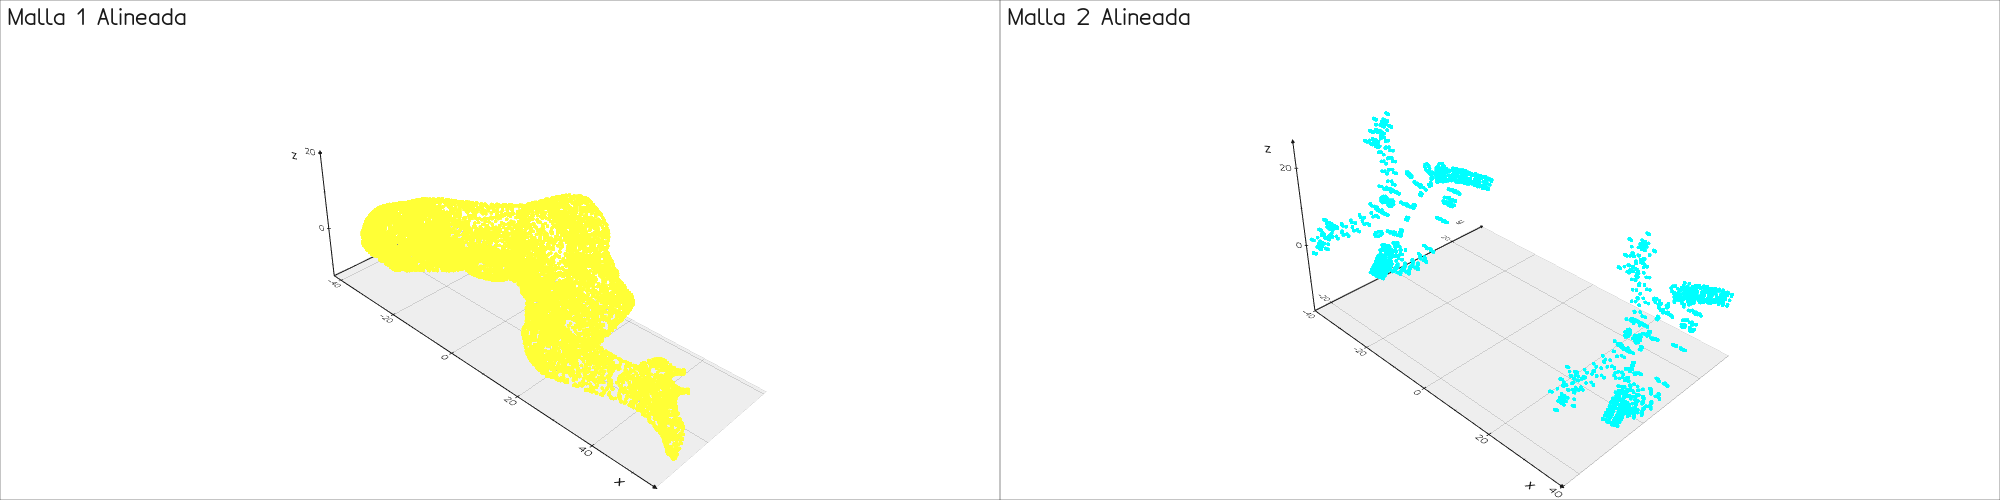

In [4]:
import numpy as np
import trimesh
from vedo import Plotter, Points
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# Función para calcular la compacidad discreta de una malla voxelizada
def calculate_discrete_compacity(voxels):
    voxel_points = voxels.points
    n = len(voxel_points)
    
    # Crear una matriz de adyacencia 3D
    adj_matrix = np.zeros((n, 6), dtype=bool)
    
    # Definir desplazamientos para vecinos adyacentes en 6 direcciones
    neighbors = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])
    
    voxel_set = set(map(tuple, voxel_points))
    
    for i, point in enumerate(voxel_points):
        for j, neighbor in enumerate(neighbors):
            neighbor_point = tuple(point + neighbor)
            if neighbor_point in voxel_set:
                adj_matrix[i, j] = True
    
    # Área de contacto (caras expuestas)
    A_c = 6 * n - adj_matrix.sum()
    
    # A_min y A_max según fórmulas teóricas para la compacidad
    A_min = n - 1
    A_max = 3 * (n - n ** (2 / 3))
    
    # Calcular la compacidad discreta
    if A_max - A_min == 0:  # Evitar división por cero
        return 1.0
    compacity = (A_c - A_min) / (A_max - A_min)
    
    return compacity

# Función para mover los vóxeles con la menor distancia usando el método húngaro
def move_voxels_hungarian(source_points, target_points):
    # Calcular la matriz de costos (distancias)
    cost_matrix = np.linalg.norm(source_points[:, np.newaxis] - target_points, axis=2)
    
    # Resolver el problema de asignación usando el método húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Obtener los vóxeles movidos
    moved_voxels = target_points[col_ind]
    
    return moved_voxels, row_ind, col_ind

# Cargar los archivos .obj
scene1 = trimesh.load_mesh('D://respaldo//todo//Ai_lab_school//vision//escalamiento_3d//Chica_9824.obj')
scene2 = trimesh.load_mesh('D://respaldo//todo//Ai_lab_school//vision//escalamiento_3d//Banca_9824.obj')

# Verificar si la carga fue una escena con múltiples geometrías
if isinstance(scene1, trimesh.Scene):
    combined_mesh1 = trimesh.util.concatenate(scene1.dump())
else:
    combined_mesh1 = scene1

if isinstance(scene2, trimesh.Scene):
    combined_mesh2 = trimesh.util.concatenate(scene2.dump())
else:
    combined_mesh2 = scene2

print("Meshes loaded and combined.")

# Alineación usando PCA
points1 = combined_mesh1.vertices
points2 = combined_mesh2.vertices

pca1 = PCA(n_components=3)
pca2 = PCA(n_components=3)

pca1.fit(points1)
pca2.fit(points2)

aligned_points1 = pca1.transform(points1)
aligned_points2 = pca2.transform(points2)

print(aligned_points1)
print("Componentes principales de la malla 1 (Sphere.obj):")
print(pca1.components_)
print("Componentes principales de la malla 2 (Cubo.obj):")
print(pca2.components_)

# Crear mallas alineadas
aligned_mesh1 = trimesh.Trimesh(vertices=aligned_points1, faces=combined_mesh1.faces)
aligned_mesh2 = trimesh.Trimesh(vertices=aligned_points2, faces=combined_mesh2.faces)

# Convertir las mallas a vóxeles
voxels1 = aligned_mesh1.voxelized(pitch=1.0)
voxels2 = aligned_mesh2.voxelized(pitch=1.0)

# Calcular la compacidad discreta de las mallas voxelizadas
compacity1 = calculate_discrete_compacity(voxels1)
compacity2 = calculate_discrete_compacity(voxels2)

print(f"Compacidad de la malla 1: {compacity1}")
print(f"Compacidad de la malla 2: {compacity2}")

voxel_points1 = voxels1.points
voxel_points2 = voxels2.points

# Mover los vóxeles de la primera malla a la segunda con la menor distancia usando el método húngaro
moved_voxel_points, row_ind, col_ind = move_voxels_hungarian(voxel_points1, voxel_points2)

# Crear un volumen de la matriz de vóxeles movidos
moved_volume = Points(moved_voxel_points, r=4, c='green')

# Crear volúmenes de las matrices de vóxeles
volume1 = Points(voxel_points1, r=4, c='red')
volume2 = Points(voxel_points2, r=4, c='blue')

# Visualizar los volúmenes escalados y voxelizados
plotter = Plotter(shape=(1, 3), size=(2000, 500))
plotter.show(volume1, "Malla 1 Escalada y Voxelizada", at=0, axes=1, viewup="z", zoom=1)
plotter.show(volume2, "Malla 2 Escalada y Voxelizada", at=1, axes=1, viewup="z", zoom=1)
plotter.show(moved_volume, "Vóxeles Movidos", at=2, axes=1, viewup="z", zoom=1.5)


# Visualizar las mallas alineadas usando PCA
aligned_volume1 = Points(aligned_points1, r=4, c='yellow')
aligned_volume2 = Points(aligned_points2, r=4, c='cyan')

# Crear un nuevo plotter para las mallas alineadas
plotter_aligned = Plotter(shape=(1, 2), size=(2000, 500))
plotter_aligned.show(aligned_volume1, "Malla 1 Alineada", at=0, axes=1, viewup="z", zoom=1)
plotter_aligned.show(aligned_volume2, "Malla 2 Alineada", at=1, axes=1, viewup="z", zoom=1)

